In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
from sklearn.datasets import make_circles
n_samples=1000
X,y= make_circles(n_samples,
                 noise=0.03,
                 random_state=42)

In [3]:
len(X),len(y)

(1000, 1000)

In [4]:
X[:5],y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [5]:
circles=pd.DataFrame({"X1":X[:,0],
                     "X2":X[:,1],
                     "label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


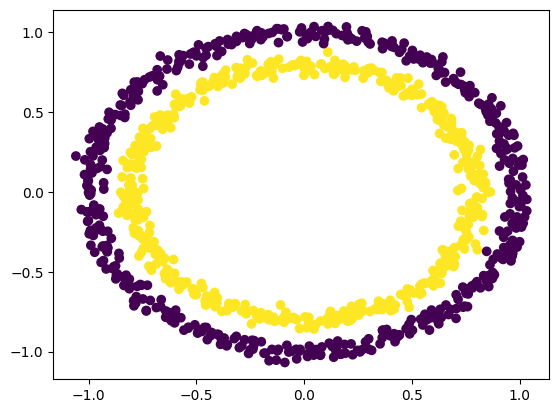

In [6]:
plt.scatter(x=X[:,0],
           y=X[:,1],
           c=y,
           # cmap=plt.cm.RdYlBu
           )

In [7]:
X.shape,y.shape

((1000, 2), (1000,))

In [8]:
torch.__version__

'2.7.0+cu118'

In [9]:
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
type(X),X.dtype,y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [11]:
from sklearn.model_selection import train_test_split

torch.manual_seed(42)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


In [12]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
class CirclemodelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1=nn.Linear(in_features=2,out_features=5)
        self.layer_2=nn.Linear(in_features=5,out_features=1)
    def forward(self,x):
        return self.layer_2(self.layer_1(x))
model_0=CirclemodelV1().to(device)
model_0    

CirclemodelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
device

'cuda'

In [15]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [16]:
#model using sequential
model_0=nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [18]:
untrained_pred=model_0(X_test.to(device))
print(f"length of prediction {len(untrained_pred)} , shape : {untrained_pred.shape}")
untrained_pred[:10]

length of prediction 200 , shape : torch.Size([200, 1])


tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0', grad_fn=<SliceBackward0>)

In [19]:
torch.round(untrained_pred[:10])

tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [20]:
loss_fn=nn.BCEWithLogitsLoss()
# loss_fn=nn.BCELoss() THIS REQUIRES THE SIGMOID FUNCTION TO BE USED
optimizer= torch.optim.SGD(params=model_0.parameters(),
                          lr=0.1)

In [21]:
def accuracy_fn(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    acc=(correct/len(y_pred))*100
    return acc

In [22]:
model_0.eval()
with torch.inference_mode():
    y_logits=model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [23]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [24]:
y_pred_probs=torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

In [25]:
y_pred_labels=torch.round(y_pred_probs).squeeze(dim=1)

In [26]:
print(torch.eq(y_test[:5].to(device),y_pred_labels.to(device)))

tensor([False,  True,  True,  True,  True], device='cuda:0')


In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epochs):
    model_0.train()
    y_logits=model_0(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits,
                  y_train)
    acc=accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #test
    model_0.eval()
    with torch.inference_mode():
        test_logits=model_0(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))

        test_loss=loss_fn(test_logits,
                         y_test)
        test_acc=accuracy_fn(y_true=y_test,
                            y_pred=test_pred)


    if epoch%10==0:
        print(f"epoch:{epoch} |loss:{loss:.5f} acc:{acc:.2f}| test loss:{test_loss:.5f} test accuracy:{test_acc:.2f}")

epoch:0 |loss:0.69796 acc:51.88| test loss:0.69440 test accuracy:58.00
epoch:10 |loss:0.69590 acc:51.25| test loss:0.69305 test accuracy:53.00
epoch:20 |loss:0.69490 acc:51.62| test loss:0.69254 test accuracy:49.50
epoch:30 |loss:0.69435 acc:51.12| test loss:0.69236 test accuracy:49.50
epoch:40 |loss:0.69401 acc:50.88| test loss:0.69232 test accuracy:51.00
epoch:50 |loss:0.69378 acc:50.25| test loss:0.69234 test accuracy:50.00
epoch:60 |loss:0.69362 acc:50.00| test loss:0.69239 test accuracy:51.50
epoch:70 |loss:0.69351 acc:50.25| test loss:0.69246 test accuracy:51.00
epoch:80 |loss:0.69342 acc:49.88| test loss:0.69254 test accuracy:50.00
epoch:90 |loss:0.69336 acc:49.88| test loss:0.69262 test accuracy:53.00


In [34]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

In [36]:
import requests
from pathlib import Path

if Path("helper_function.py").is_file():
    print("helper_function.py already exists, skiping download")
else:
    print("downloading helper_fucntion.py")
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions,plot_decision_boundary


downloading helper_fucntion.py


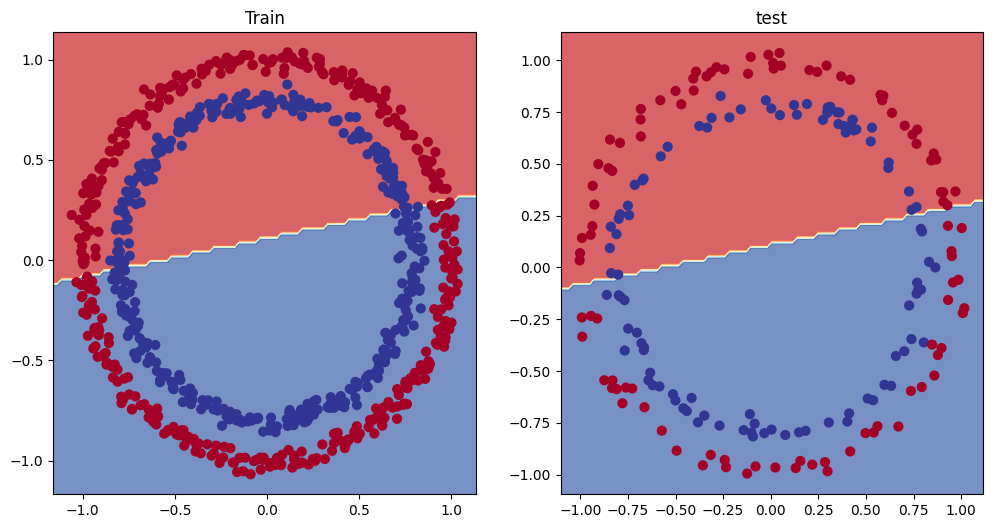

In [37]:
#use helper fucntion
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_0,X_test,y_test)

In [40]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0849, -0.2762],
                      [ 0.4610, -0.5187],
                      [-0.3271, -0.1947],
                      [-0.4220,  0.0507],
                      [-0.7016,  0.6600]])),
             ('0.bias', tensor([-0.6060,  0.5246,  0.1149, -0.2211,  0.4275])),
             ('1.weight',
              tensor([[ 0.0741,  0.2406,  0.0222, -0.1075,  0.1965]])),
             ('1.bias', tensor([-0.1888]))])

In [42]:
#now we have to change the model to fit the curves rather than the linear

In [46]:
#improving the model based on the model perspective
class CirclemodelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1=nn.Linear(in_features=2,out_features=10)
        self.layer_2=nn.Linear(in_features=10,out_features=10)
        self.layer_3=nn.Linear(in_features=10,out_features=1)
    def forward(self,x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
model_1=CirclemodelV2().to(device)
model_1

CirclemodelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [52]:
loss_fn=nn.BCEWithLogitsLoss()
# loss_fn=nn.BCELoss() THIS REQUIRES THE SIGMOID FUNCTION TO BE USED
optimizer= torch.optim.SGD(params=model_1.parameters(),
                          lr=0.1)

In [56]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000

X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    y_logits=model_1(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))
    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_true=y_train,y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits=model_1(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))

        test_loss=loss_fn(test_logits,
                         y_test)
        test_acc=accuracy_fn(y_true=y_test,
                            y_pred=test_pred)


    if epoch%100==0:
        print(f"epoch:{epoch} |loss:{loss:.5f} acc:{acc:.2f}%| test loss:{test_loss:.5f} test accuracy:{test_acc:.2f}%")

epoch:0 |loss:0.69528 acc:51.38%| test loss:0.69252 test accuracy:50.50%
epoch:100 |loss:0.69325 acc:47.88%| test loss:0.69283 test accuracy:51.00%
epoch:200 |loss:0.69309 acc:49.88%| test loss:0.69344 test accuracy:46.50%
epoch:300 |loss:0.69303 acc:50.50%| test loss:0.69384 test accuracy:47.50%
epoch:400 |loss:0.69300 acc:51.38%| test loss:0.69412 test accuracy:46.50%
epoch:500 |loss:0.69299 acc:51.12%| test loss:0.69431 test accuracy:46.00%
epoch:600 |loss:0.69298 acc:51.50%| test loss:0.69444 test accuracy:46.00%
epoch:700 |loss:0.69298 acc:51.38%| test loss:0.69452 test accuracy:45.50%
epoch:800 |loss:0.69298 acc:51.50%| test loss:0.69458 test accuracy:44.50%
epoch:900 |loss:0.69298 acc:51.38%| test loss:0.69461 test accuracy:45.00%


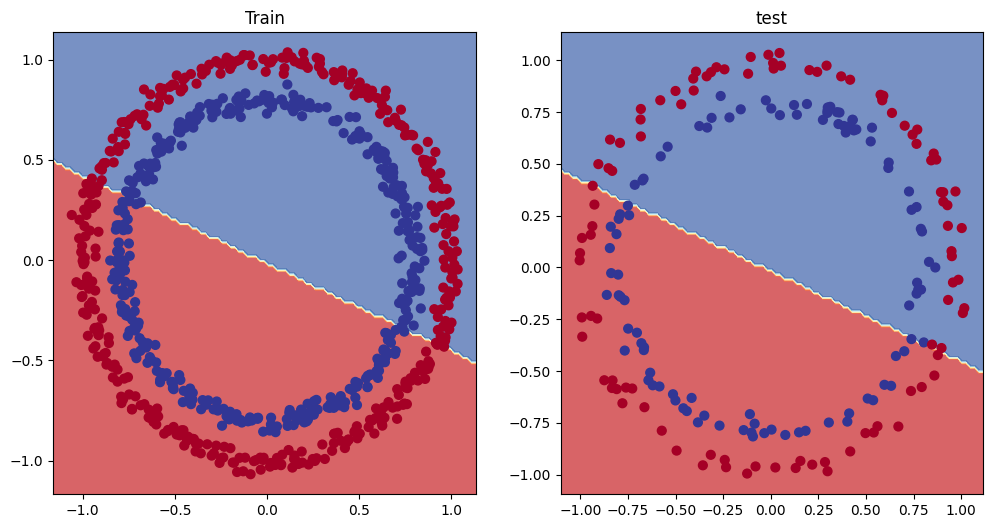

In [58]:
#use helper fucntion
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_1,X_test,y_test)

In [60]:
#to see if the model can even learn anything

In [108]:
#trying the linear data
weight=0.7
bias=0.3
start=0
end=1
step=0.01

X_regression=torch.arange(start,end,step).unsqueeze(dim=1)

y_regression=weight*X_regression+bias

print(len(X_regression))
X_regression[:5],y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [110]:
from sklearn.model_selection import train_test_split

torch.manual_seed(42)
X_train_regression,X_test_regression,y_train_regression,y_test_regression=train_test_split(X_regression,y_regression,test_size=0.2,random_state=42)


In [112]:
len(X_train_regression),len(X_test_regression)

(80, 20)

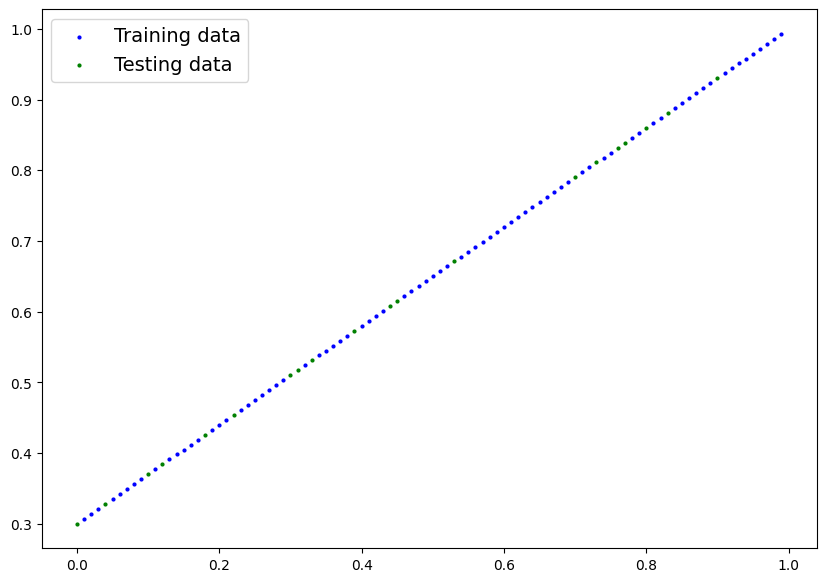

In [114]:
#from helper function
plot_predictions(train_data=X_train_regression,
                train_labels=y_train_regression,
                test_data=X_test_regression,
                test_labels=y_test_regression)

In [116]:
#adjust the model_1 to fit these linear data
model_2=nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [118]:
#loss and optimizer
loss_fn=nn.L1Loss()
optimizer=torch.optim.SGD(params=model_2.parameters(),
                         lr=0.001)

In [120]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000

X_train_regression,y_train_regression=X_train_regression.to(device),y_train_regression.to(device)
X_test_regression,y_test_regression=X_test_regression.to(device),y_test_regression.to(device)

for epoch in range(epochs):
    y_pred=model_2(X_train_regression)
    loss=loss_fn(y_pred,y_train_regression)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    model_1.eval()
    with torch.inference_mode():
        test_pred=model_2(X_test_regression)

        test_loss=loss_fn(test_pred,
                         y_test_regression)


    if epoch%100==0:
        print(f"epoch:{epoch} |loss:{loss:.5f}| test loss:{test_loss:.5f}")

epoch:0 |loss:0.80353| test loss:0.77528
epoch:100 |loss:0.41583| test loss:0.39712
epoch:200 |loss:0.02830| test loss:0.02202
epoch:300 |loss:0.00263| test loss:0.00142
epoch:400 |loss:0.00246| test loss:0.00158
epoch:500 |loss:0.00228| test loss:0.00174
epoch:600 |loss:0.00211| test loss:0.00190
epoch:700 |loss:0.00193| test loss:0.00205
epoch:800 |loss:0.00176| test loss:0.00221
epoch:900 |loss:0.00159| test loss:0.00237


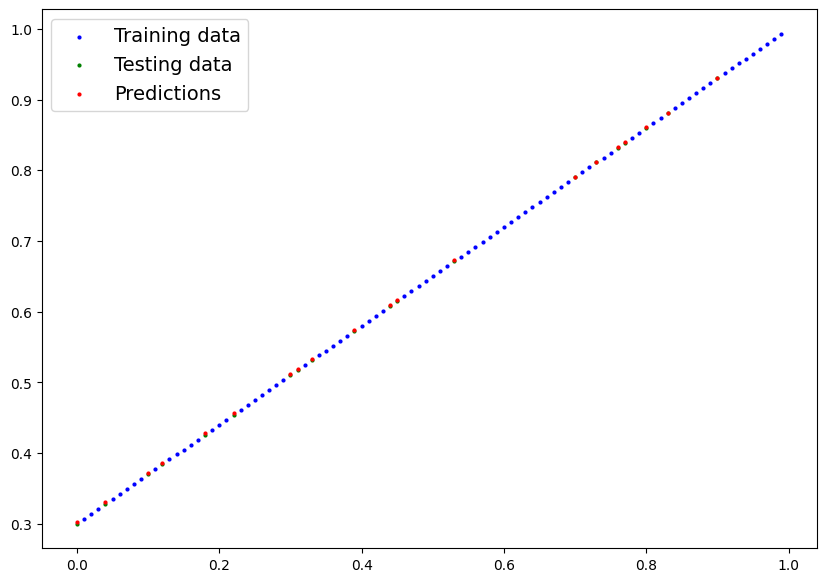

In [106]:
model_2.eval()

with torch.inference_mode():
    y_preds=model_2(X_test_regression)
#from helper function
plot_predictions(train_data=X_train_regression.cpu(),
                train_labels=y_train_regression.cpu(),
                test_data=X_test_regression.cpu(),
                test_labels=y_test_regression.cpu(),
                predictions=y_preds.cpu())

In [122]:
#now using the non linearility


In [124]:
#starting over

In [216]:
from sklearn.datasets import make_circles
n_samples=1000
X,y= make_circles(n_samples,
                 noise=0.03,
                 random_state=42)

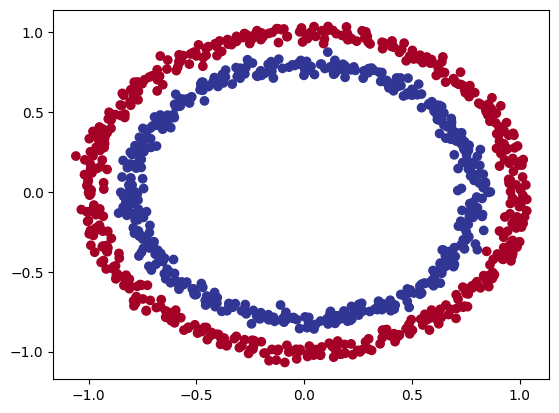

In [218]:
plt.scatter(x=X[:,0],
           y=X[:,1],
           c=y,
           cmap=plt.cm.RdYlBu
           )

In [220]:
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

from sklearn.model_selection import train_test_split

torch.manual_seed(42)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


In [222]:
#model with non linear functions
class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1=nn.Linear(in_features=2,out_features=10)
        self.layer_2=nn.Linear(in_features=10,out_features=10)
        self.layer_3=nn.Linear(in_features=10,out_features=1)
        self.relu=nn.ReLU()
    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
model_3=CircleModelV3().to(device)
model_3

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [224]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model_3.parameters(),
                         lr=0.1)

In [226]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

epochs=1000
for epoch in range(epochs):
    model_3.train()

    y_logits=model_3(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))

    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_true=y_train,
                   y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_3.eval()
    with torch.inference_mode():
        test_logits=model_3(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))

        test_loss=loss_fn(test_logits,
                         y_test)
        test_acc=accuracy_fn(y_true=y_test,
                            y_pred=test_pred)


    if epoch%100==0:
        print(f"epoch:{epoch} |loss:{loss:.5f} acc:{acc:.2f}%| test loss:{test_loss:.5f} test accuracy:{test_acc:.2f}%")

epoch:0 |loss:0.69295 acc:50.00%| test loss:0.69319 test accuracy:50.00%
epoch:100 |loss:0.69115 acc:52.88%| test loss:0.69102 test accuracy:52.50%
epoch:200 |loss:0.68977 acc:53.37%| test loss:0.68940 test accuracy:55.00%
epoch:300 |loss:0.68795 acc:53.00%| test loss:0.68723 test accuracy:56.00%
epoch:400 |loss:0.68517 acc:52.75%| test loss:0.68411 test accuracy:56.50%
epoch:500 |loss:0.68102 acc:52.75%| test loss:0.67941 test accuracy:56.50%
epoch:600 |loss:0.67515 acc:54.50%| test loss:0.67285 test accuracy:56.00%
epoch:700 |loss:0.66659 acc:58.38%| test loss:0.66322 test accuracy:59.00%
epoch:800 |loss:0.65160 acc:64.00%| test loss:0.64757 test accuracy:67.50%
epoch:900 |loss:0.62362 acc:74.00%| test loss:0.62145 test accuracy:79.00%


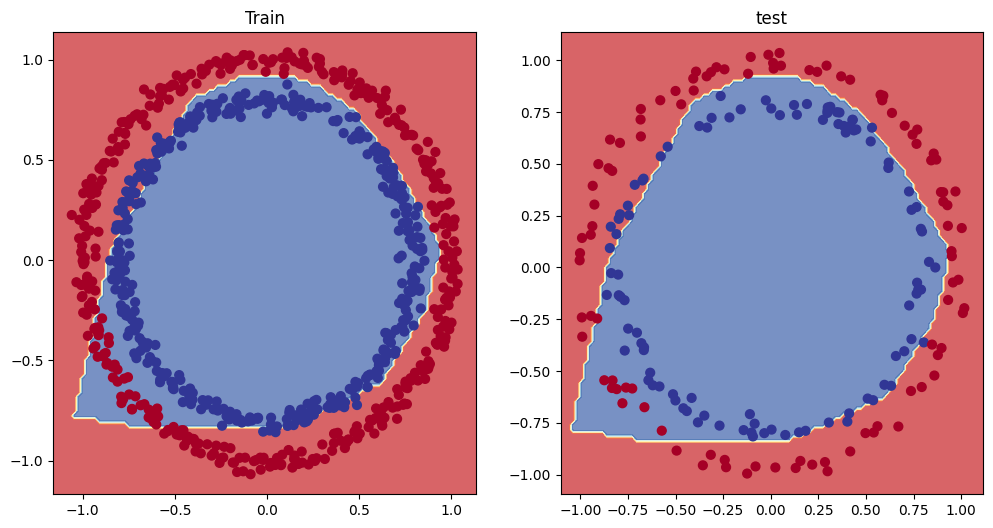

In [228]:
#use helper fucntion
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_3,X_test,y_test)

In [234]:
#making a non linear activation function
A=torch.arange(-10,10,1,dtype=torch.float32)
A.dtype

torch.float32

In [236]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

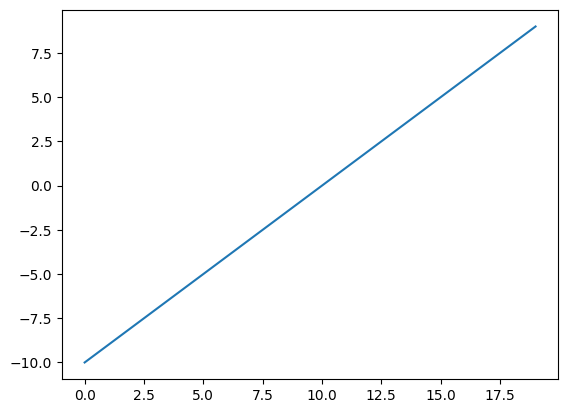

In [238]:
plt.plot(A)

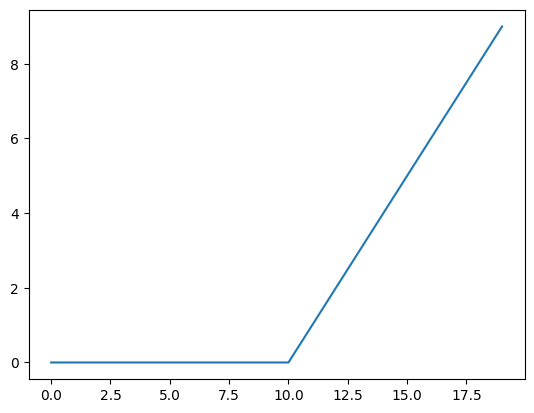

In [240]:
plt.plot(torch.relu(A))

In [244]:
def relu(x:torch.Tensor)->torch.Tensor:
    return torch.maximum(torch.tensor(0),x)
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

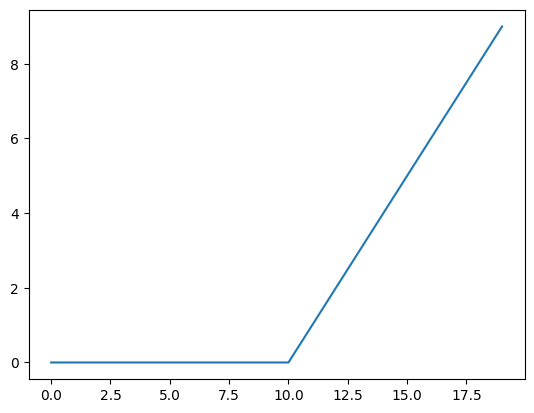

In [246]:
plt.plot(relu(A))

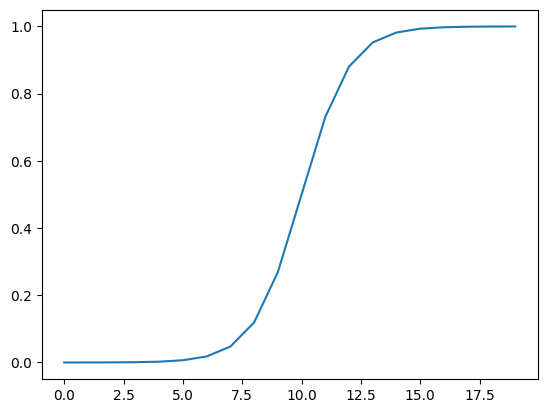

In [248]:
plt.plot(torch.sigmoid(A))

In [268]:
def sig(x:torch.Tensor)->torch.Tensor:
    return 1/(1+torch.exp(-x))
sig(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

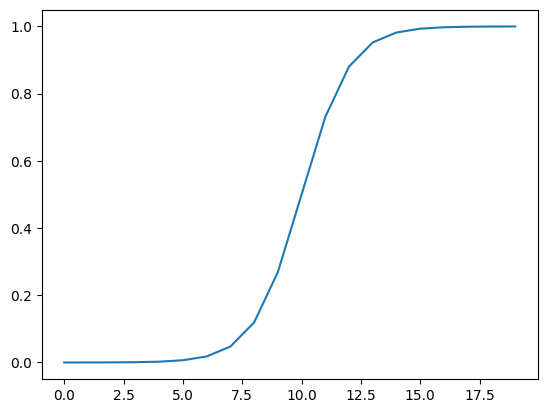

In [270]:
plt.plot(sig(A))

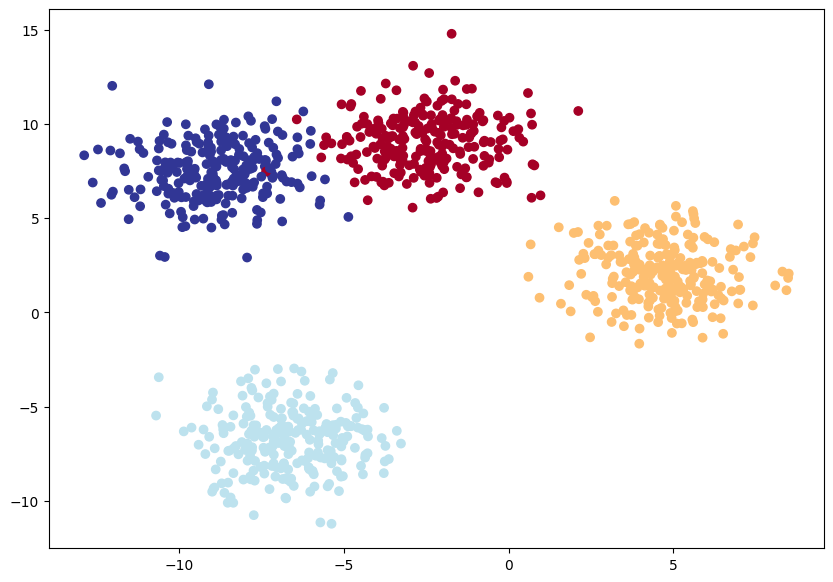

In [351]:
#multiclass classification
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

NUM_CLASSES=4
NUM_FEATURES=2
RANDOM_SEED=42

x_blob,y_blob=make_blobs(n_samples=1000,
                         n_features=NUM_FEATURES,
                         centers=NUM_CLASSES,
                         cluster_std=1.5,
                         random_state=RANDOM_SEED)
x_blob=torch.from_numpy(x_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)

x_blob_train,x_blob_test,y_blob_train,y_blob_test=train_test_split(x_blob,
                                                                   y_blob,
                                                                   test_size=0.2,
                                                                   random_state=RANDOM_SEED)
plt.figure(figsize=(10,7))
plt.scatter(x_blob[:,0],x_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

In [353]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [391]:
class BlobModel(nn.Module):
    def __init__(self,input_feature,output_feature,hidden_units=8):
        super().__init__()
        self.linear_layer_stack=nn.Sequential(
            nn.Linear(in_features=input_feature,out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_feature)
        )
    def forward(self,x):
        return self.linear_layer_stack(x)
model_4=BlobModel(input_feature=2,output_feature=4,hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [393]:
x_blob_train.shape

torch.Size([800, 2])

In [395]:
torch.unique(y_blob_test)

tensor([0, 1, 2, 3], device='cuda:0')

In [397]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_4.parameters(),
                         lr=0.1)

In [399]:
next(model_4.parameters()).device

device(type='cuda', index=0)

In [401]:
x_blob_test.device

device(type='cuda', index=0)

In [403]:
model_4.eval()
with torch.inference_mode():
    y_logits=model_4(x_blob_test.to(device))
y_logits[:10]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852],
        [ 2.0878, -1.3728,  2.1248,  2.5052],
        [ 1.8310,  0.8851,  2.1674,  0.6006],
        [ 0.1412, -1.4742, -0.0360,  1.0373],
        [ 2.9426,  0.7047,  3.3670,  1.6184],
        [-0.0645, -1.5006, -0.2666,  0.8940]], device='cuda:0')

In [405]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [407]:
#using of activation function(using logits for the predictions probablities)
y_pred_probs=torch.softmax(y_logits,dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0')
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0')


In [409]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [411]:
torch.max(y_pred_probs[0])

tensor(0.3715, device='cuda:0')

In [413]:
torch.argmax(y_pred_probs[0])

tensor(3, device='cuda:0')

In [415]:
#conver the pred prob to prediction labels
y_preds=torch.argmax(y_pred_probs,dim=1)
y_preds

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3], device='cuda:0')

In [417]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [419]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=100

x_blob_train,y_blob_train=x_blob_train.to(device),y_blob_train.to(device)
x_blob_test,y_blob_test=x_blob_test.to(device),y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()
    y_logits=model_4(x_blob_train)
    y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)

    loss=loss_fn(y_logits,y_blob_train)
    acc=accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_4.eval()
    with torch.inference_mode():
        test_logits=model_4(x_blob_test)
        test_pred=torch.softmax(test_logits,dim=1).argmax(dim=1)

        test_loss=loss_fn(test_logits,
                         y_blob_test)
        test_acc=accuracy_fn(y_true=y_blob_test,
                            y_pred=test_pred)


    if epoch%10==0:
        print(f"epoch:{epoch} |loss:{loss:.5f} acc:{acc:.2f}%| test loss:{test_loss:.5f} test accuracy:{test_acc:.2f}%")
    

epoch:0 |loss:1.04324 acc:65.50%| test loss:0.57861 test accuracy:95.50%
epoch:10 |loss:0.14398 acc:99.12%| test loss:0.13037 test accuracy:99.00%
epoch:20 |loss:0.08062 acc:99.12%| test loss:0.07216 test accuracy:99.50%
epoch:30 |loss:0.05924 acc:99.12%| test loss:0.05133 test accuracy:99.50%
epoch:40 |loss:0.04892 acc:99.00%| test loss:0.04098 test accuracy:99.50%
epoch:50 |loss:0.04295 acc:99.00%| test loss:0.03486 test accuracy:99.50%
epoch:60 |loss:0.03910 acc:99.00%| test loss:0.03083 test accuracy:99.50%
epoch:70 |loss:0.03643 acc:99.00%| test loss:0.02799 test accuracy:99.50%
epoch:80 |loss:0.03448 acc:99.00%| test loss:0.02587 test accuracy:99.50%
epoch:90 |loss:0.03300 acc:99.12%| test loss:0.02423 test accuracy:99.50%


In [420]:
#USING THE HELPER FUNCTION FOR THE VISUALIZATION
model_4.eval()
with torch.inference_mode():
    y_logits=model_4(x_blob_test)
y_pred_probs=torch.softmax(y_logits,dim=1).argmax(dim=1)
y_pred_probs

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [423]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

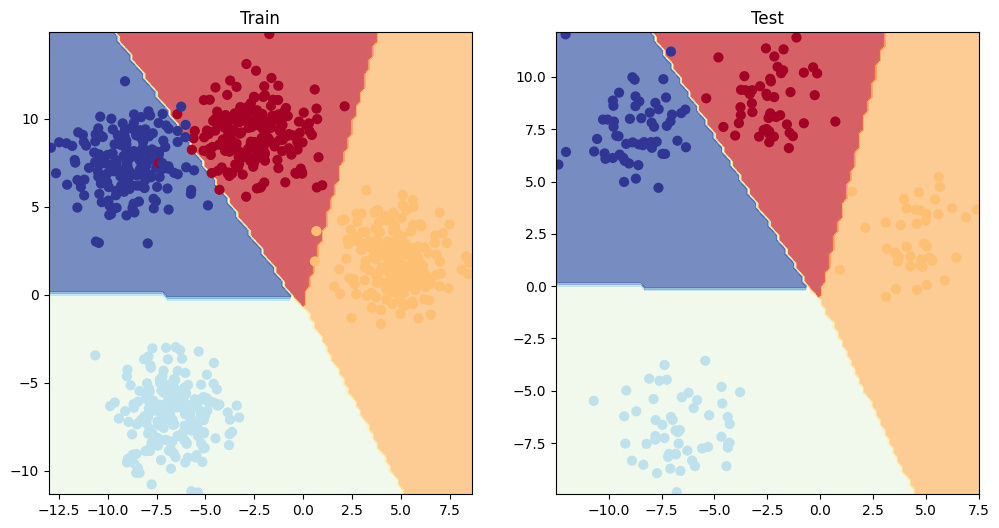

In [425]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,x_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,x_blob_test,y_blob_test)

In [429]:
#classification meterics
!pip install torchmetrics

  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/961.5 kB ? eta -:--:--
   --------------------------------------- 961.5/961.5 kB 14.9 MB/s eta 0:00:00
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.2
    Uninstalling sympy-1.13.2:
      Successfully uninstalled sympy-1.13.2


In [473]:
from torchmetrics.classification import Accuracy
import torch

torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

acc = torchmetrics_accuracy( y_blob_test,y_pred_probs)
print(f"Accuracy: {acc.item()*100:.2f}%")


Accuracy: 99.50%


# exercise

In [2]:
!nvidia-smi

Wed May 28 13:31:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   50C    P8              5W /   75W |     343MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [145]:
from sklearn.datasets import make_moons

NUM_SAMPLES=1000
RANDOM_SEED=42

X,y=make_moons(n_samples=NUM_SAMPLES,
               noise=0.07,
               random_state=RANDOM_SEED)

X[:10],y[:10]

(array([[-0.03341062,  0.4213911 ],
        [ 0.99882703, -0.4428903 ],
        [ 0.88959204, -0.32784256],
        [ 0.34195829, -0.41768975],
        [-0.83853099,  0.53237483],
        [ 0.59906425, -0.28977331],
        [ 0.29009023, -0.2046885 ],
        [-0.03826868,  0.45942924],
        [ 1.61377123, -0.2939697 ],
        [ 0.693337  ,  0.82781911]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0], dtype=int64))

In [147]:
import pandas as pd
data_df=pd.DataFrame({"X0":X[:,0],
                      "X1":X[:,1],
                      "y":y})
data_df.head()

,X0,X1,y
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0


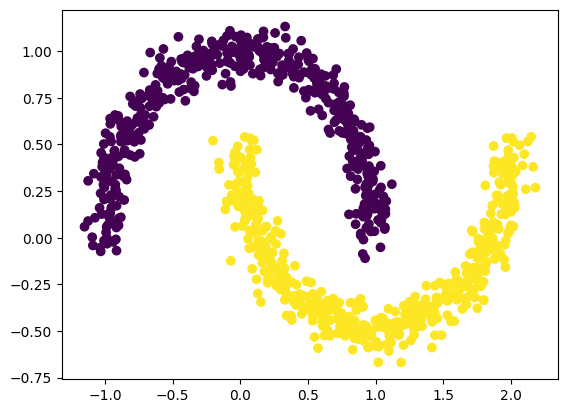

In [149]:
import matplotlib.pyplot as plt
plt.scatter(data_df["X0"],data_df["X1"],c=data_df["y"])

In [151]:
import torch
X=torch.tensor(X,dtype=torch.float)
y=torch.tensor(y,dtype=torch.float)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,
                                              y,
                                              test_size=0.2,
                                              random_state=RANDOM_SEED)
len(X_train),len(X_test)

(800, 200)

In [153]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [155]:
import torch
import torch.nn as nn

class testmodel(nn.Module):
    def __init__(self,input_features,output_features,hidden_units):
        super().__init__()
        self.layer1=nn.Linear(in_features=input_features,
                              out_features=hidden_units,)
        self.layer2=nn.Linear(in_features=hidden_units,
                             out_features=hidden_units)
        self.layer3=nn.Linear(in_features=hidden_units,
                             out_features=output_features)
        self.relu=nn.ReLU()
    def forward(self,x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
model_test=testmodel(input_features=2,output_features=1,hidden_units=10).to(device)
model_test
        

testmodel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [157]:
model_test.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, 

In [159]:
logits=model_test(X_train.to(device)[:10]).squeeze()
print(logits)
pred_probs=torch.sigmoid(logits)
print(pred_probs)
pred_labels=torch.round(pred_probs)
print(pred_labels)

tensor([0.0019, 0.0094, 0.0161, 0.0185, 0.0284, 0.0192, 0.0291, 0.0196, 0.0258,
        0.0079], device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([0.5005, 0.5024, 0.5040, 0.5046, 0.5071, 0.5048, 0.5073, 0.5049, 0.5065,
        0.5020], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<RoundBackward0>)


In [161]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_test.parameters(),
                          lr=0.1)

In [163]:
from torchmetrics.classification import Accuracy

torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=2).to(device)


In [165]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000

X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epochs):
    model_test.train()
    y_logits=model_test(X_train).squeeze()
    y_preds=torch.round(torch.sigmoid(y_logits))
    loss=loss_fn(y_logits,y_train)
    acc = torchmetrics_accuracy( y_train,y_preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_test.eval()
    with torch.inference_mode():
        test_logits=model_test(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))
        test_loss=loss_fn(test_logits,y_test)
        test_acc = torchmetrics_accuracy( y_test,test_pred)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc*100:.2f}% | Test loss: {test_loss:.2f} Test acc: {test_acc*100:.2f}%")
    

Epoch: 0 | Loss: 0.70 Acc: 37.38% | Test loss: 0.69 Test acc: 49.50%
Epoch: 100 | Loss: 0.39 Acc: 81.62% | Test loss: 0.40 Test acc: 76.00%
Epoch: 200 | Loss: 0.24 Acc: 88.50% | Test loss: 0.24 Test acc: 89.50%
Epoch: 300 | Loss: 0.20 Acc: 90.88% | Test loss: 0.19 Test acc: 93.50%
Epoch: 400 | Loss: 0.17 Acc: 92.88% | Test loss: 0.15 Test acc: 94.00%
Epoch: 500 | Loss: 0.12 Acc: 95.12% | Test loss: 0.11 Test acc: 96.00%
Epoch: 600 | Loss: 0.08 Acc: 97.88% | Test loss: 0.07 Test acc: 98.50%
Epoch: 700 | Loss: 0.06 Acc: 99.00% | Test loss: 0.05 Test acc: 99.50%
Epoch: 800 | Loss: 0.04 Acc: 99.25% | Test loss: 0.03 Test acc: 99.50%
Epoch: 900 | Loss: 0.03 Acc: 99.75% | Test loss: 0.02 Test acc: 100.00%


In [167]:
import requests
from pathlib import Path

if Path("helper_function.py").is_file():
    print("helper_function.py already exists, skiping download")
else:
    print("downloading helper_fucntion.py")
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions,plot_decision_boundary


downloading helper_fucntion.py


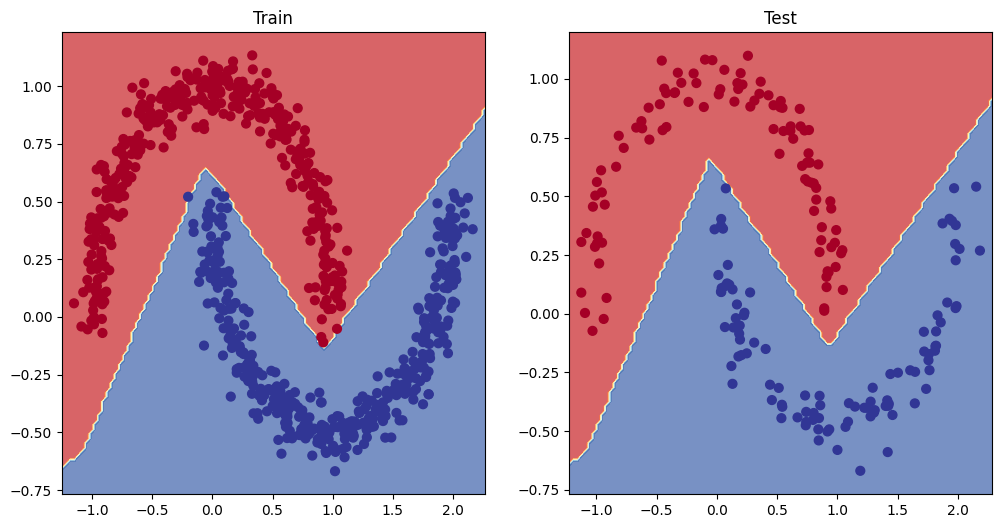

In [169]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_test,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_test,X_test,y_test)